In [1]:
import numpy as np
import tensorflow as tf
from collections import Counter
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
text = """
Knowledge is the pathway to discovery. Learning transforms our understanding of the world, opening doors to endless possibilities. Creativity is the spark that ignites innovation, allowing us to explore new ideas and perspectives. As we journey through life, curiosity leads us to question, to wonder, and to grow. Persistence in the face of challenges builds resilience and character. Together, knowledge, creativity, and perseverance form the foundation of human progress. Each word we speak, each thought we nurture, contributes to a shared narrative of growth and understanding. Embrace the joy of learning, and let your curiosity guide you.
"""

words = text.lower().split()
vocab = set(words)
vocab_size = len(vocab)

word_to_ix = {word: i for i, word in enumerate(vocab)}
ix_to_word = {i: word for word, i in word_to_ix.items()}

In [3]:
context_size = 2

def generate_context_target_pairs(words, context_size):
    pairs = []
    for i in range(context_size, len(words) - context_size):
        context = words[i - context_size:i] + words[i + 1:i + context_size + 1]
        target = words[i]
        pairs.append((context, target))
    return pairs

data = generate_context_target_pairs(words, context_size)


In [4]:
X = []
y = []

for context, target in data:
    X.append([word_to_ix[w] for w in context])
    y.append(word_to_ix[target])

X = np.array(X)
y = np.array(y)


In [5]:
class CBOW(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOW, self).__init__()
        self.embeddings = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.linear = tf.keras.layers.Dense(vocab_size)

    def call(self, context_words):
        embedded = self.embeddings(context_words)
        context_vector = tf.reduce_mean(embedded, axis=1)
        out = self.linear(context_vector)
        return out


In [6]:
embedding_dim = 50
model = CBOW(vocab_size, embedding_dim)
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)


In [7]:
epochs = 100
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        predictions = model(X)
        loss = loss_function(y, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    if epoch % 20 == 0:
        print(f"Epoch: {epoch}, Loss: {loss.numpy():.4f}")


Epoch: 0, Loss: 4.2611
Epoch: 20, Loss: 4.2582
Epoch: 40, Loss: 4.2553
Epoch: 60, Loss: 4.2524
Epoch: 80, Loss: 4.2496


In [8]:
embeddings = model.embeddings.weights[0].numpy()

In [9]:
def find_similar_words(word, embeddings, word_to_ix, ix_to_word, top_n=5):
    word_vec = embeddings[word_to_ix[word]]
    similarities = np.dot(embeddings, word_vec) / (
        np.linalg.norm(embeddings, axis=1) * np.linalg.norm(word_vec) + 1e-9
    )
    closest_words = similarities.argsort()[-(top_n + 1):-1]
    return [ix_to_word[idx] for idx in closest_words]

test_word = "creativity"
similar_words = find_similar_words(test_word, embeddings, word_to_ix, ix_to_word)
print(f"Words similar to '{test_word}': {similar_words}")


Words similar to 'creativity': ['and', 'is', 'journey', 'life,', 'wonder,']


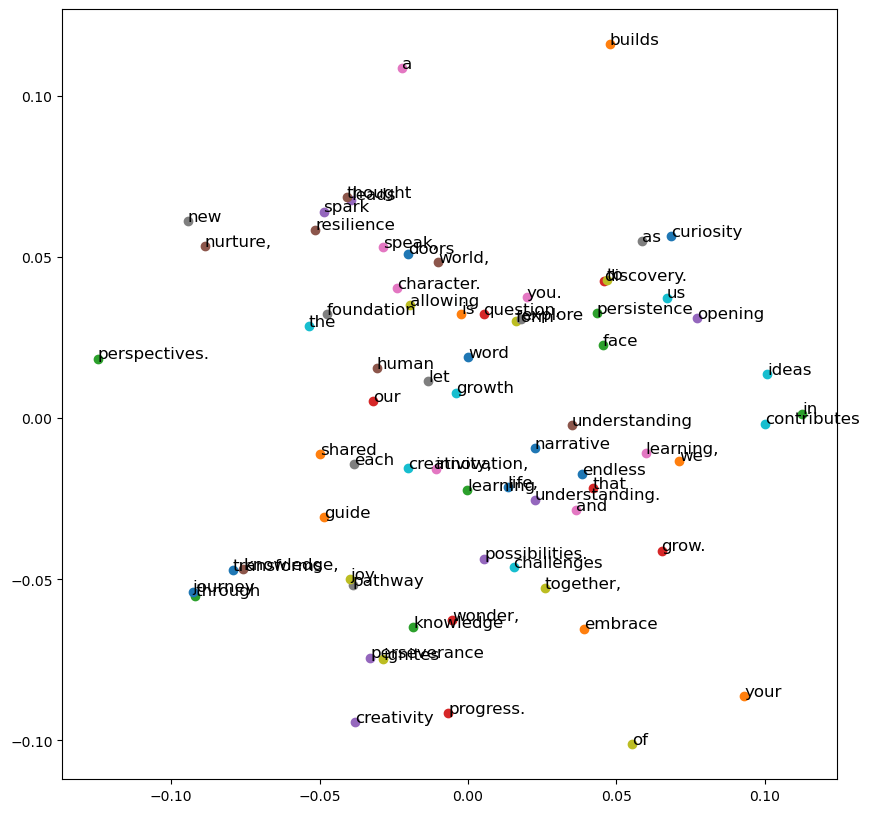

In [10]:
def visualize_embeddings(embeddings, word_to_ix):
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embeddings)
    plt.figure(figsize=(10, 10))
    for word, idx in word_to_ix.items():
        x, y = reduced_embeddings[idx]
        plt.scatter(x, y)
        plt.text(x, y, word, fontsize=12)
    plt.show()

visualize_embeddings(embeddings, word_to_ix)
